***PREPARAZIONE DATASET***

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from joblib import Parallel, delayed
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# URL del dataset
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv"

# Caricare il dataset
data = pd.read_csv(url)

# Visualizzare le prime righe del dataset per avere un'idea dei dati
print(data.head())

# Separare il target (prezzo) dalle feature
X = data.drop("price", axis=1)
y = data["price"]

# Identificare le colonne numeriche e categoriche
numeric_features = ["area", "bedrooms", "bathrooms", "stories", "parking"]
categorical_features = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea", "furnishingstatus"]

# Preprocessing per le colonne numeriche (imputazione dei valori mancanti e scalatura)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing per le colonne categoriche (imputazione e codifica one-hot)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Creare il preprocessore combinando le trasformazioni
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Suddivisione del dataset in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creazione della pipeline di preprocessing al fine di sostituire i valori nal con la media e di applicare poi la standardizzazione
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])


# Applicazione della pipeline di preprocessing ai dati
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus  
0                 1  
1                 1  
2                 2  
3                 1  
4                 1  


***CREAZIONE E ADDESTRAMENTO DEI MODELLI DI REGRESSIONE***

In [ ]:
# Funzione per valutare un modello sui dataset di training e test
def evaluate_initial_model(model, model_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"{model_name} - Training Set - MSE: {train_rmse:.4f}, R-squared: {train_r2:.4f}")
    print(f"{model_name} - Test Set - MSE: {test_rmse:.4f}, R-squared: {test_r2:.4f}")
    print("-" * 50)

# Inizializzazione dei modelli con parametri di default
ridge = Ridge()
lasso = Lasso(max_iter=10000)
elastic_net = ElasticNet(max_iter=10000)

# Valutazione dei modelli
evaluate_initial_model(ridge, "Ridge Regression")
evaluate_initial_model(lasso, "Lasso Regression")
evaluate_initial_model(elastic_net, "Elastic Net Regression")


Ridge Regression - Training Set - MSE: 798262.4580, R-squared: 0.7933
Ridge Regression - Test Set - MSE: 1406563.6874, R-squared: 0.6086
--------------------------------------------------
Lasso Regression - Training Set - MSE: 798243.7369, R-squared: 0.7933
Lasso Regression - Test Set - MSE: 1408954.1167, R-squared: 0.6073
--------------------------------------------------
Elastic Net Regression - Training Set - MSE: 873331.6211, R-squared: 0.7526
Elastic Net Regression - Test Set - MSE: 1393177.2901, R-squared: 0.6160
--------------------------------------------------


In [ ]:
"""sembrano vi siano margini di miglioramento dei r quadro dei modelli
si puo effettuare un tentativo per migliorare tali parametri e modelli
attraverso la cross validation e la ricerca ottimale dei parametri di regolarizzazione
"""
# Funzione di valutazione del modello
def evaluate_model_cv(model, X, y, model_name):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf, n_jobs=-1)

    mean_mse = -np.mean(mse_scores)
    std_mse = np.std(mse_scores)
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)

    print(f"{model_name} - Cross-Validation - Mean Squared Error: {mean_mse:.4f} ± {std_mse:.4f}, R-squared: {mean_r2:.4f} ± {std_r2:.4f}")

# Funzione per eseguire la random search e valutare i modelli
def random_search_and_evaluate_cv(model, param_distributions, model_name, n_iter=10):
    random_search = RandomizedSearchCV(model, param_distributions, n_iter=n_iter,
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

    try:
        # Eseguire la ricerca dei migliori iperparametri
        random_search.fit(X_train, y_train)
        best_params = random_search.best_params_

        # Addestrare il modello con i migliori iperparametri
        best_model = model.set_params(**best_params)
        best_model.fit(X_train, y_train)

        # Valutazione del modello con cross-validation
        evaluate_model_cv(best_model, X_train, y_train, model_name)

        return best_model, best_params
    except Exception as e:
        print(f"Errore durante il fitting del modello {model_name}: {e}")
        return None, None

# Definizione dei parametri di ricerca per RandomizedSearchCV
param_distributions_ridge = {'alpha': np.logspace(-4, 4, 200)}
param_distributions_lasso = {'alpha': np.logspace(-4, 4, 200)}
param_distributions_en = {'alpha': np.logspace(-4, 4, 200), 'l1_ratio': np.linspace(0, 1, 50)}

# Esecuzione della random search e valutazione dei modelli
ridge_best, ridge_params = random_search_and_evaluate_cv(ridge, param_distributions_ridge,
        "Ridge Regression", n_iter=10)
lasso_best, lasso_params = random_search_and_evaluate_cv(lasso, param_distributions_lasso,
      "Lasso Regression", n_iter=10)
elastic_net_best, elastic_net_params = random_search_and_evaluate_cv(
elastic_net, param_distributions_en, "Elastic Net Regression", n_iter=10)

# Funzione per valutare la complessità dei modelli
def evaluate_model_complexity(model, model_name):
    if model is not None:
        non_zero_coefficients = np.sum(model.coef_ != 0)
        print(f"{model_name} - Numero di coefficienti non nulli: {non_zero_coefficients}")
    else:
        print(f"Il modello {model_name} non è stato addestrato correttamente.")

# DataFrame per raccogliere i risultati
results_df = pd.DataFrame(columns=['Model', 'Dataset', 'R-squared'])

# Funzione per visualizzare la distribuzione dei residui
def plot_residuals(y_true, y_pred, model_name, dataset_type):
    residuals = y_true - y_pred
    plt.figure(figsize=(18, 6))

    # Scatter plot dei residui
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred, residuals)
    plt.xlabel('Valori Predetti')
    plt.ylabel('Residui')
    plt.title(f'Residui vs Valori Predetti ({model_name} - {dataset_type})')
    plt.axhline(0, color='red', linestyle='--')

    # Istogramma dei residui
    plt.subplot(1, 3, 2)
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel('Residui')
    plt.title(f'Distribuzione dei Residui ({model_name} - {dataset_type})')

    # Q-Q plot dei residui
    plt.subplot(1, 3, 3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot dei Residui ({model_name} - {dataset_type})')

    plt.tight_layout()
    plt.show()



# Funzione per visualizzare l'andamento dei coefficienti
def plot_coefficient_paths(model, param_name, param_range, X, y, model_name):
    coefs = []

    # Parallelizzare l'addestramento dei modelli
    def fit_model(param):
        model.set_params(**{param_name: param})
        model.fit(X, y)
        return model.coef_

    coefs = Parallel(n_jobs=-1)(delayed(fit_model)(param) for param in param_range)

    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.plot(param_range, coefs)
    ax.set_xscale('log')
    plt.xlabel(f"{param_name}")
    plt.ylabel("Coefficienti")
    plt.title(f"Andamento dei Coefficienti ({model_name})")
    plt.axis('tight')
    plt.show()






# Valutazione finale sui test set
def final_evaluation(model, model_name, results_df):
    if model is not None:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        print(f"{model_name} - Training Set - RMSE: {train_rmse:.4f}, R-squared: {train_r2:.4f}")
        print(f"{model_name} - Test Set - RMSE: {test_rmse:.4f}, R-squared: {test_r2:.4f}")

        # Aggiungere i risultati al DataFrame
        results_df = pd.concat([results_df, pd.DataFrame({'Model': [model_name], 'Dataset': ['Training'], 'R-squared': [train_r2]})], ignore_index=True)
        results_df = pd.concat([results_df, pd.DataFrame({'Model': [model_name], 'Dataset': ['Test'], 'R-squared': [test_r2]})], ignore_index=True)

        # Valutare la complessità del modello
        evaluate_model_complexity(model, model_name)
    else:
        print(f"Il modello {model_name} non è stato addestrato correttamente.")

    return results_df






Ridge Regression - Cross-Validation - Mean Squared Error: 1082766096667.0078 ± 222694638071.7001, R-squared: 0.6422 ± 0.0562
Lasso Regression - Cross-Validation - Mean Squared Error: 1637912182971.0032 ± 597332176158.9590, R-squared: 0.4777 ± 0.1152
Elastic Net Regression - Cross-Validation - Mean Squared Error: 1075954294032.0280 ± 218151665321.8455, R-squared: 0.6445 ± 0.0550


***VALUTAZIONE DELLE PERFORMANCE***


In [ ]:
# Valutazione finale per i modelli ottimizzati
results_df = final_evaluation(ridge_best, "Ridge Regression", results_df)
results_df = final_evaluation(lasso_best, "Lasso Regression", results_df)
results_df = final_evaluation(elastic_net_best, "Elastic Net Regression", results_df)

# Verifica che results_df sia definito e popolato
print(results_df)




Ridge Regression - Training Set - RMSE: 875436.6709, R-squared: 0.7514
Ridge Regression - Test Set - RMSE: 1394364.2676, R-squared: 0.6153
Ridge Regression - Numero di coefficienti non nulli: 90
Lasso Regression - Training Set - RMSE: 798409.8492, R-squared: 0.7933
Lasso Regression - Test Set - RMSE: 1404576.0881, R-squared: 0.6097
Lasso Regression - Numero di coefficienti non nulli: 82
Elastic Net Regression - Training Set - RMSE: 854360.1843, R-squared: 0.7633
Elastic Net Regression - Test Set - RMSE: 1383832.2778, R-squared: 0.6211
Elastic Net Regression - Numero di coefficienti non nulli: 90
                    Model   Dataset  R-squared
0        Ridge Regression  Training   0.751446
1        Ridge Regression      Test   0.615348
2        Lasso Regression  Training   0.793261
3        Lasso Regression      Test   0.609693
4  Elastic Net Regression  Training   0.763270
5  Elastic Net Regression      Test   0.621137


<ipython-input-3-ddac9d5c7bd5>:136: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'Model': [model_name], 'Dataset': ['Training'], 'R-squared': [train_r2]})], ignore_index=True)


***VISUALIZZAZIONE RISULTATI***


In [ ]:
"""Rappresentiamo graficamente i risultati ottenuti con r2
che sembrano leggermente migliorati e avendo un buon livello"""




'Rappresentiamo graficamente i risultati ottenuti con r2\nche sembrano leggermente migliorati e avendo un buon livello'

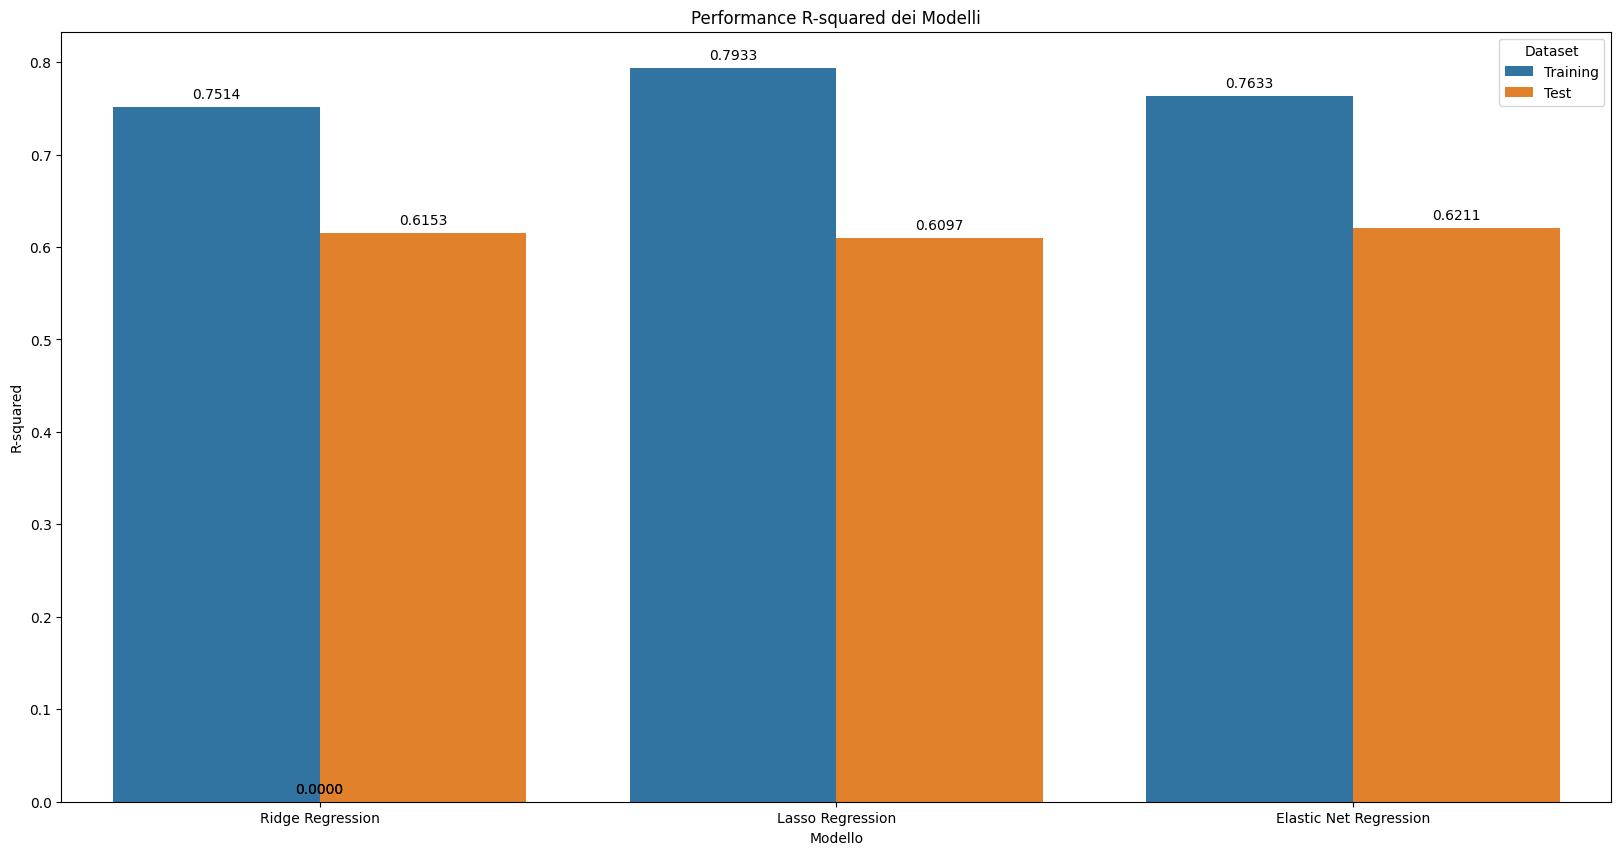

In [ ]:
# Visualizzazione dei risultati
plt.figure(figsize=(20, 10))
barplot = sns.barplot(x='Model', y='R-squared', hue='Dataset', data=results_df)
plt.title('Performance R-squared dei Modelli')
plt.ylabel('R-squared')
plt.xlabel('Modello')

# Aggiunta dei valori di R-squared sulle barre
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.4f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.show()


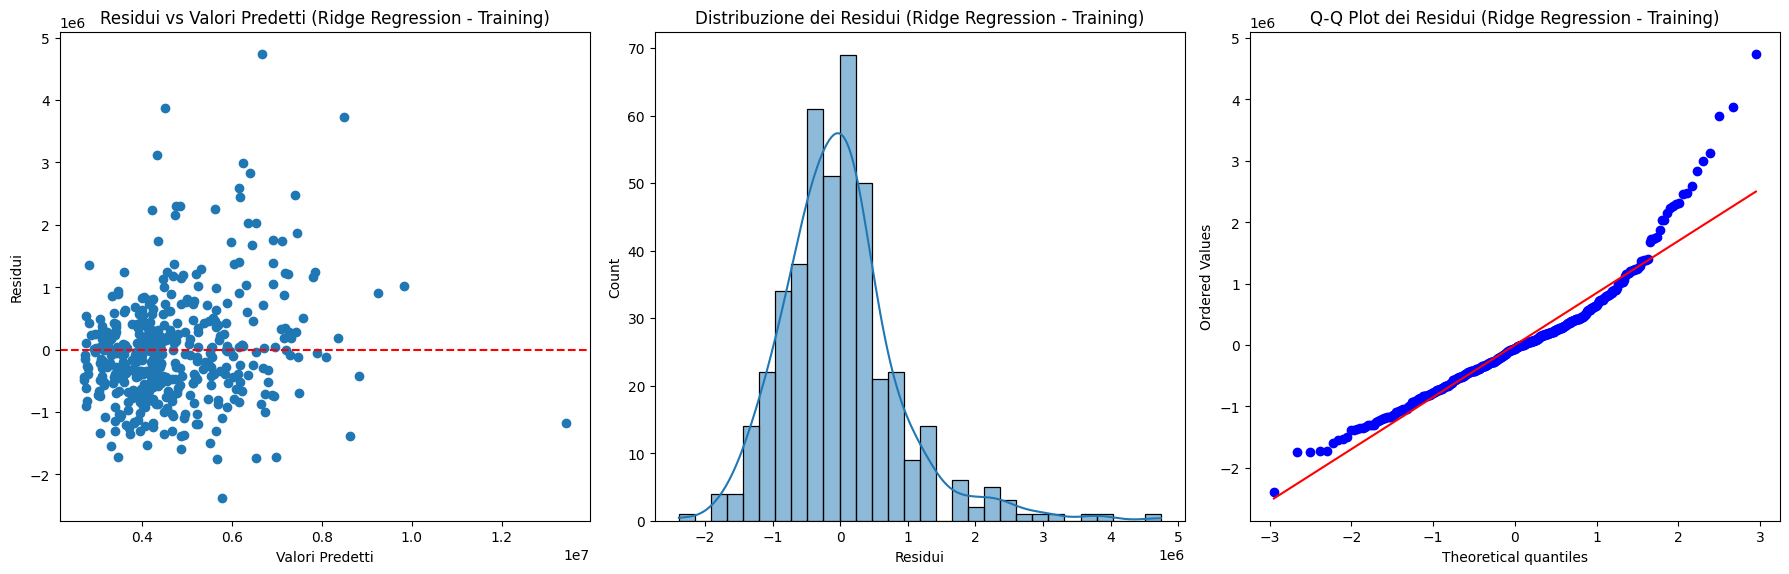

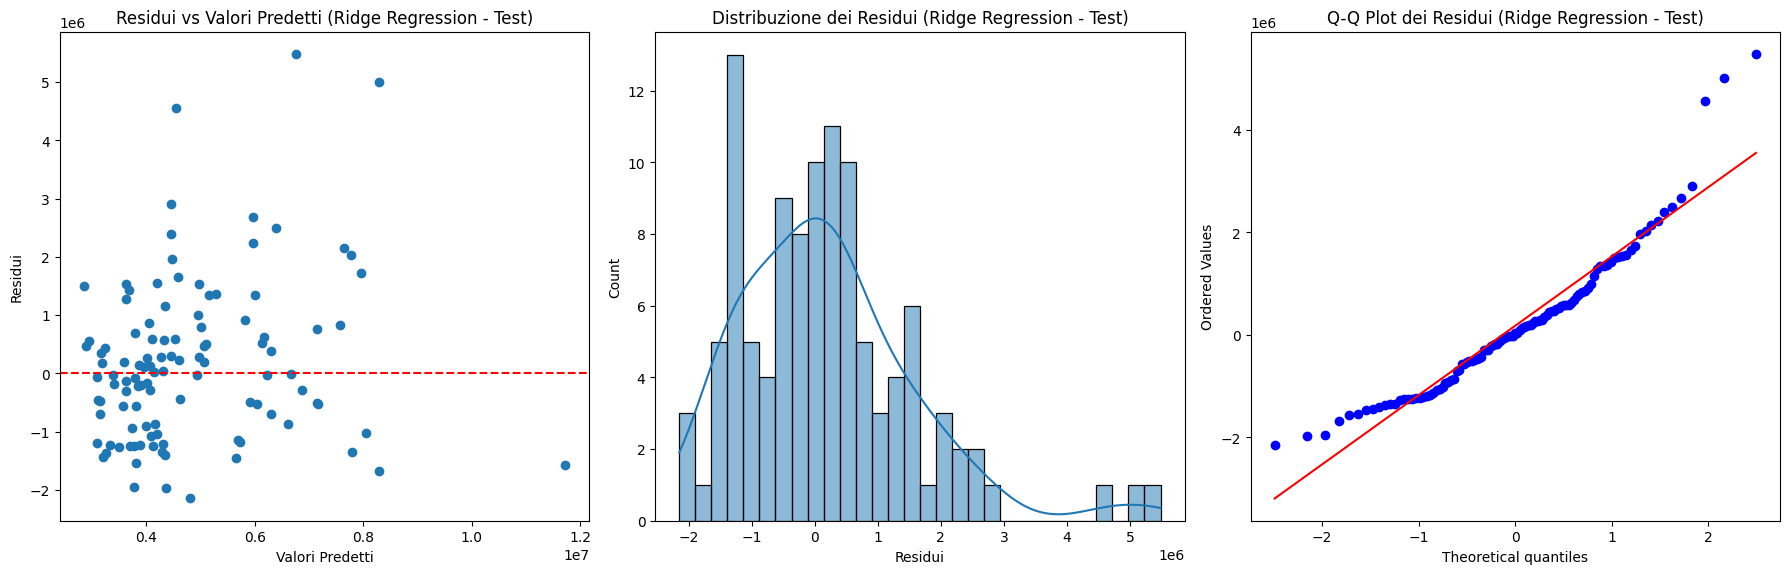

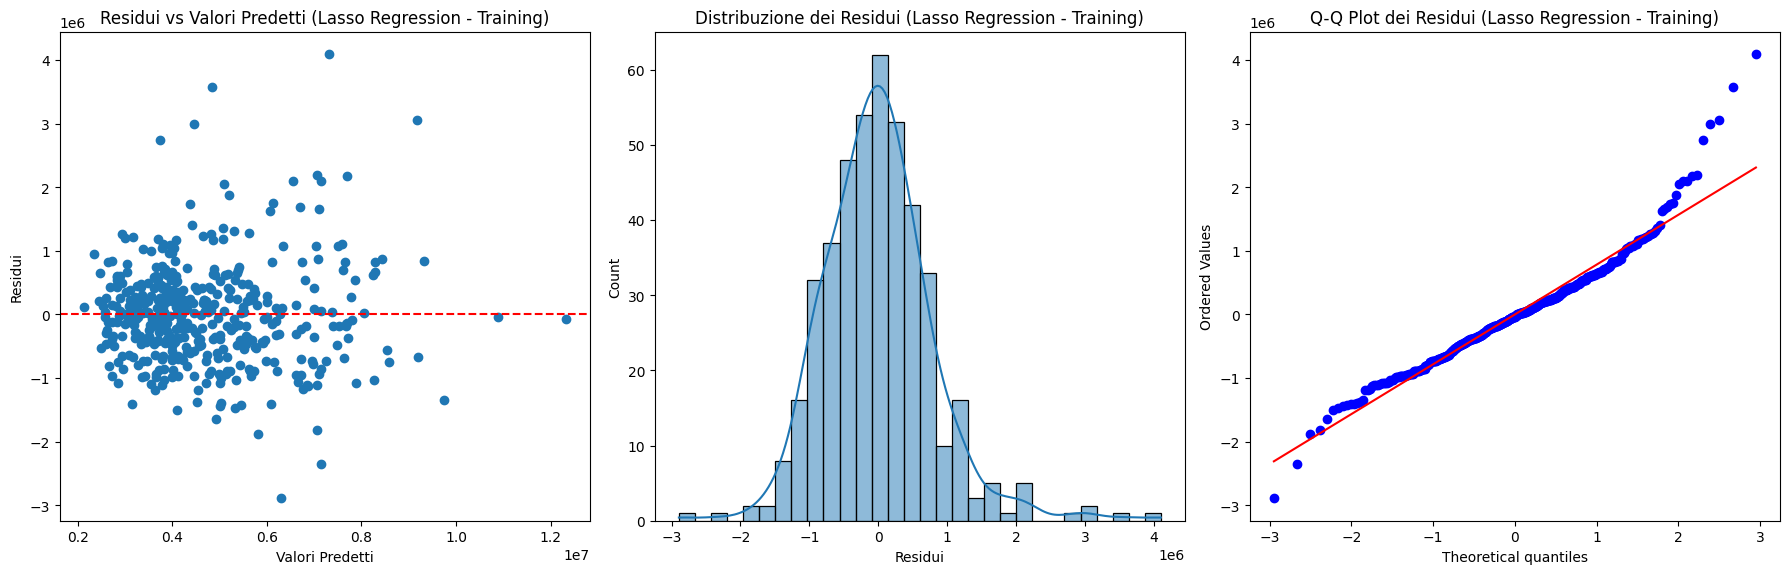

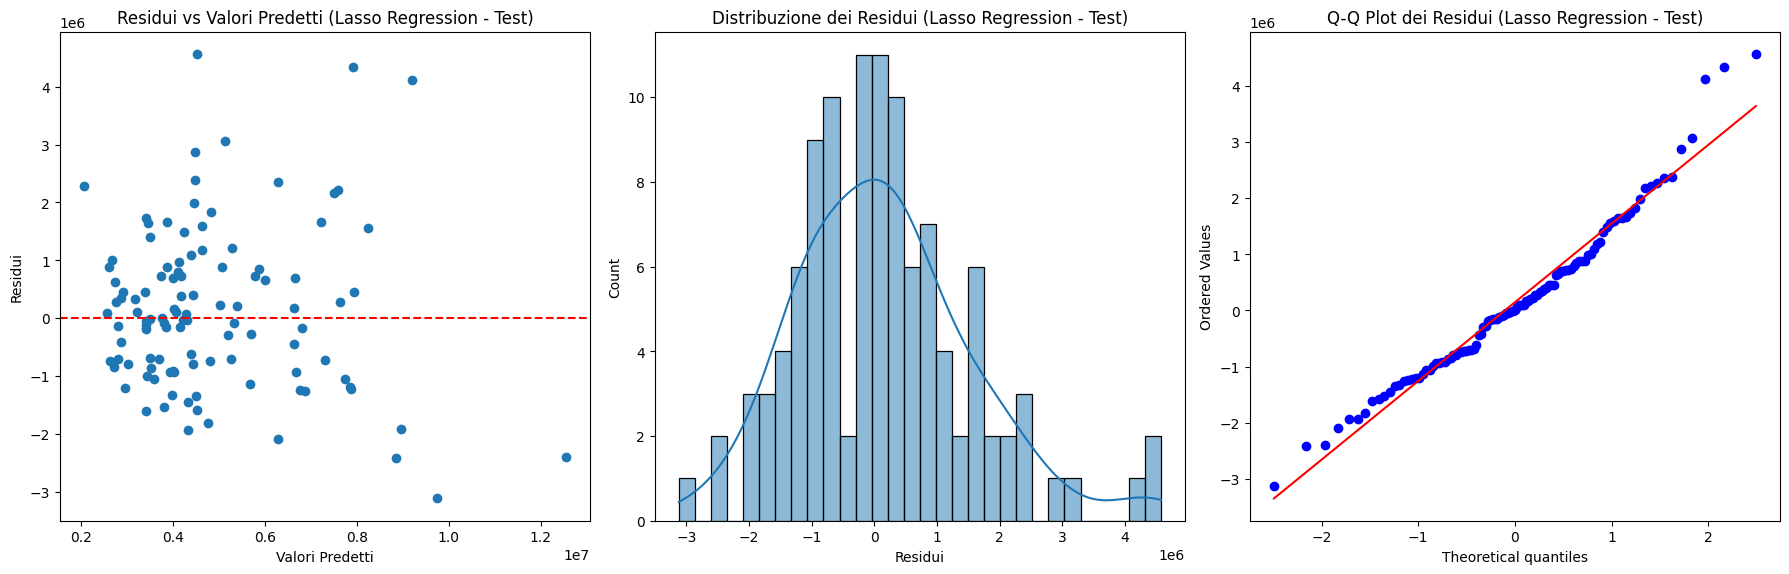

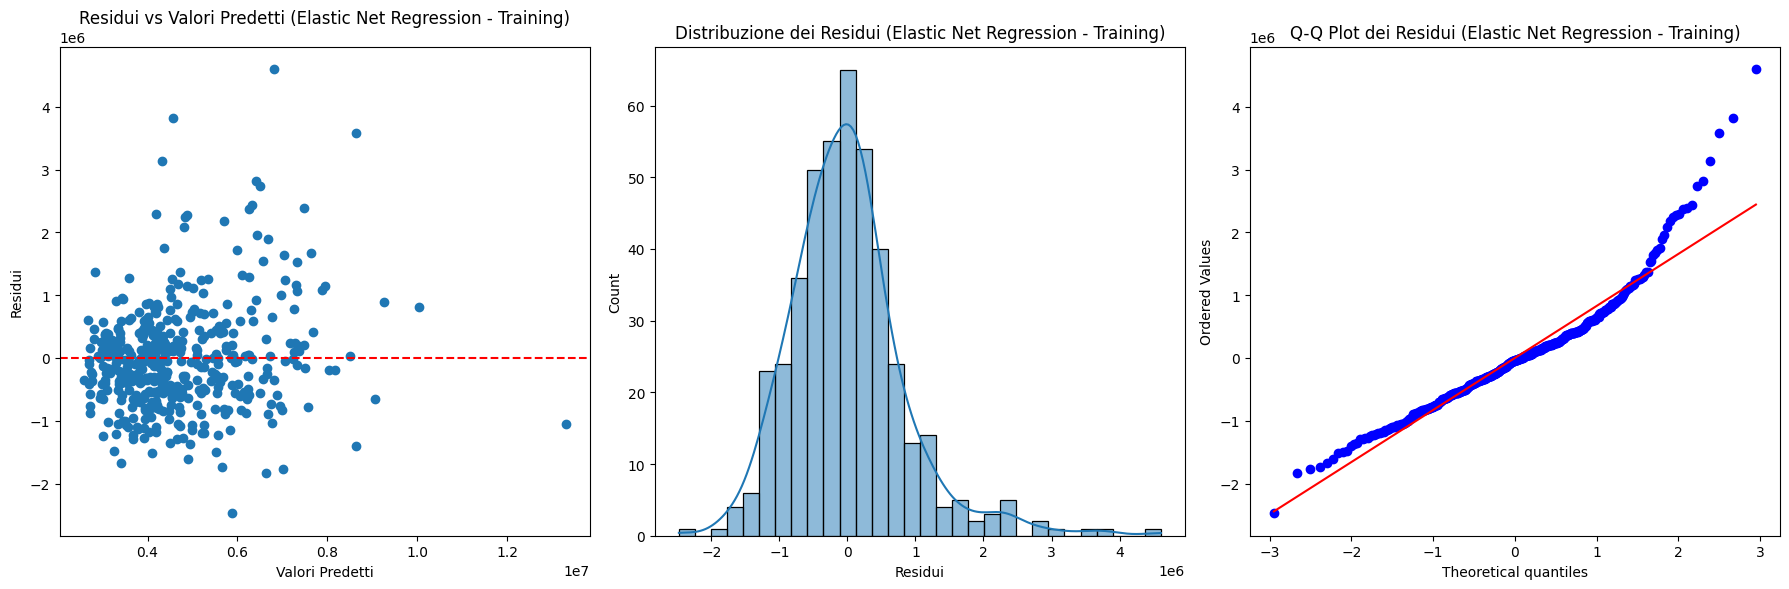

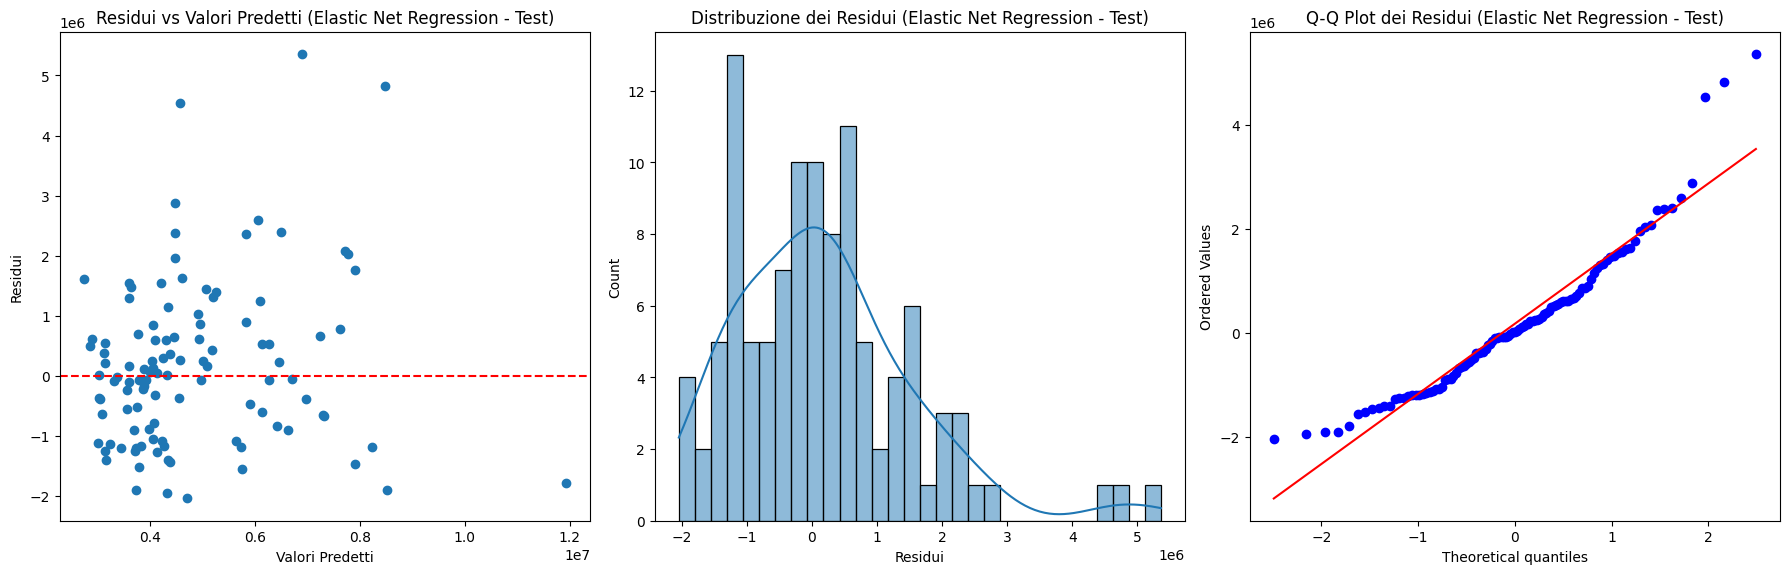

In [ ]:
# Visualizzazione della distribuzione dei residui
def visualize_residuals(models, model_names):
    for model, model_name in zip(models, model_names):
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        plot_residuals(y_train, y_train_pred, model_name, 'Training')
        plot_residuals(y_test, y_test_pred, model_name, 'Test')

models = [ridge_best, lasso_best, elastic_net_best]
model_names = ["Ridge Regression", "Lasso Regression", "Elastic Net Regression"]

visualize_residuals(models, model_names)

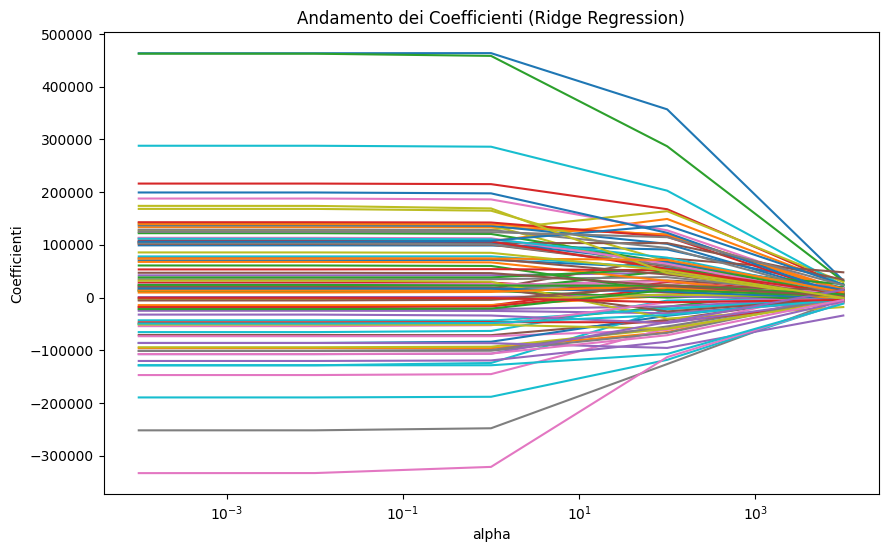

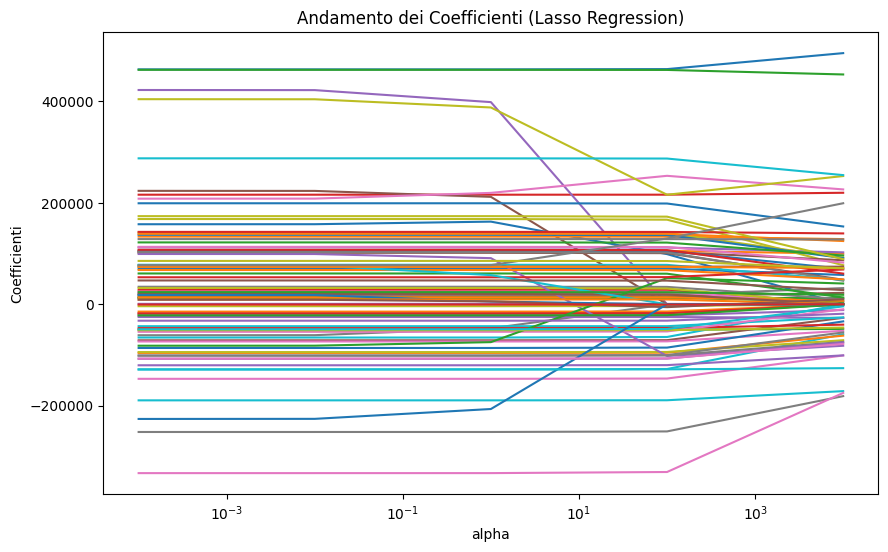

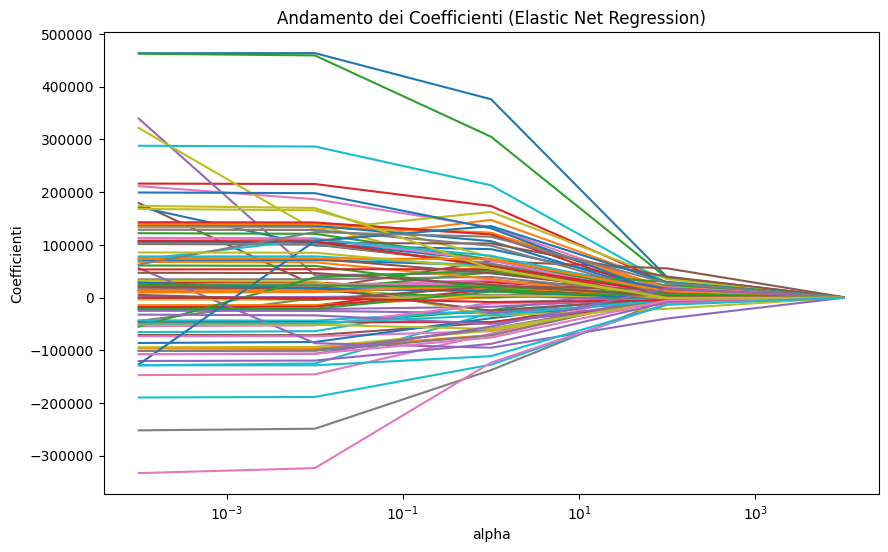

In [ ]:
# Visualizzazione dell'andamento dei coefficienti
def visualize_coefficient_paths(models, param_names, param_ranges, model_names):
    for model, param_name, param_range, model_name in zip(models, param_names, param_ranges, model_names):
        plot_coefficient_paths(model, param_name, param_range, X_train, y_train, model_name)

param_alpha_ridge = np.logspace(-4, 4,5)  # Ridotto il numero di valori a 50
param_alpha_lasso = np.logspace(-4, 4, 5)  # Ridotto il numero di valori a 50
param_alpha_en = np.logspace(-4, 4, 5)  # Ridotto il numero di valori a 50

param_ranges = [param_alpha_ridge, param_alpha_lasso, param_alpha_en]
param_names = ['alpha', 'alpha', 'alpha']

visualize_coefficient_paths(models, param_names, param_ranges, model_names)

In [ ]:
""" dalla valutazione dei tre modelli e dei loro rispettivi risultati in merito a R2,
 distribuzione dei residui degli errori e andamento dei coefficienti rispetto
 ai parametri di regolarizzazione, tutti e tre i modelli sembrano avere un molto
 simile potere predittivo sull'andamento dei prezzi del mercato immobiliare,
 spiegando all'incirca il 61% delle osservazioni della variabile dipendente,
 ovvero il prezzo delle case."""

" dalla valutazione dei tre modelli e dei loro rispettivi risultati in merito a R2,\n distribuzione dei residui degli errori e andamento dei coefficienti rispetto\n ai parametri di regolarizzazione, tutti e tre i modelli sembrano avere un molto\n simile potere predittivo sull'andamento dei prezzi del mercato immobiliare,\n spiegando all'incirca il 61% delle osservazioni della variabile dipendente,\n ovvero il prezzo delle case."